### Importing Libraries

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import statsmodels.api as sm
from pathlib import Path
from wordcloud import WordCloud
import missingno as msno
pd.set_option('display.max_columns', None)

In [108]:
def load_raw_data(filename):
    BASE_DIR = Path.cwd().parents[0]
    return pd.read_csv(BASE_DIR / "data" / "raw" / filename)


In [109]:
df = load_raw_data(r'PublicAssistanceGrantAwardActivities.csv')

In [110]:
df.shape

(948686, 23)

### **Negative Values in federalShareObligated**

During exploratory data analysis, a small number of observations in the federalShareObligated column were found to have negative values. At first glance, this may appear counterintuitive, as the variable represents FEMA’s obligated share of disaster recovery costs. However, these negative values are not data errors and do not indicate negative disaster losses.

In the FEMA Public Assistance program, funding is often obligated based on initial cost estimates and may be revised over time as projects undergo further review, scope clarification, audits, or closeout. When FEMA reduces or reverses a previously obligated amount—due to overestimation, ineligible expenses, or administrative reconciliation—the adjustment is recorded as a negative obligated value. These records therefore represent de-obligations or accounting corrections, rather than actual recovery expenditures.

From an analytical standpoint, the objective of this project is to model disaster cost severity and tail risk, where the focus is on the magnitude of financial losses associated with recovery activities. Negative obligated amounts do not reflect disaster impact or recovery cost severity; instead, they encode post-decision administrative adjustments that occur after funding has already been evaluated and approved.

For this reason, negative values of federalShareObligated were excluded from subsequent analysis and modeling. Restricting the dataset to non-negative obligated amounts ensures that the target variable represents meaningful, realized recovery costs and preserves the interpretability of quantile-based models. Given that negative values constitute only a very small fraction of the dataset, their removal does not materially affect the overall distribution but significantly improves conceptual clarity and modeling validity.

In [111]:
# Keeping only those values which are relevant
df_clean = df.loc[df.federalShareObligated>0]

In [112]:
# Preview the data
df_clean.head(3)

,region,disasterNumber,sriaDisaster,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,pnpStatus,damageCategoryCode,federalShareObligated,dateObligated,pwNumber,projectTitle,versionNumber,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,9,1397,0,EARTHQUAKE,DR,Earthquake,2001-12-05T00:00:00.000Z,GU,Guam,Statewide,000-U6K9Y-00,GUAM WATERWORKS AUTHORITY,0.0,F - Public Utilities,121.50,2002-02-01T00:00:00.000Z,37,PUMP STATION REPAIR - HAIRLINE CRACKS,0.0,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
1,4,1381,0,TROPICAL STORM ALLISON,DR,Severe Storm,2001-06-17T00:00:00.000Z,FL,Florida,Washington,133-99133-00,WASHINGTON COUNTY,0.0,C - Roads and Bridges,3116.84,2001-10-03T00:00:00.000Z,210,ROADS AND BRIDGES,0.0,E,O,C,553d4c29-85ef-4002-ad7f-0b10c0b3da19
2,6,1709,0,"SEVERE STORMS, TORNADOES, AND FLOODING",DR,Severe Storm,2007-06-29T00:00:00.000Z,TX,Texas,Henderson,213-99213-00,HENDERSON (COUNTY),0.0,C - Roads and Bridges,7211.69,2007-11-09T00:00:00.000Z,2594,ROADS AND BRIDGES,0.0,E,O,C,743771d1-7292-4009-afc7-a8258ebc4414


In [113]:
# Summary of dataset
df_clean.describe()

,region,disasterNumber,sriaDisaster,pnpStatus,federalShareObligated,pwNumber,versionNumber
count,786608.000000,786608.000000,786608.000000,777320.000000,7.866080e+05,786608.000000,777320.000000
mean,4.818339,2138.751678,0.063750,0.064336,1.269825e+05,2074.382504,0.324277
std,2.221364,974.280428,0.244307,0.245351,4.120445e+06,3226.321412,0.910622
min,1.000000,1239.000000,0.000000,0.000000,1.000000e-02,1.000000,0.000000
25%,3.000000,1574.000000,0.000000,0.000000,2.358380e+03,233.000000,0.000000
50%,5.000000,1738.000000,0.000000,0.000000,7.210565e+03,757.000000,0.000000
75%,6.000000,1973.000000,0.000000,0.000000,2.588261e+04,2352.000000,0.000000
max,10.000000,5538.000000,1.000000,1.000000,1.399420e+09,83562.000000,69.000000


In [114]:
df_clean.describe(include='O')

,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,damageCategoryCode,dateObligated,projectTitle,eligibilityStatus,fundingStatus,paCloseoutStatus,id
count,786608,786608,786608,786608,786608,786608,777317,786608,786608,786608,786608,781833,786608,786608,786608,786608
unique,1237,3,25,1616,57,59,2327,57961,62544,17,7422,380399,5,2,2,786608
top,SEVERE STORMS AND FLOODING,DR,Severe Storm,2005-08-29T00:00:00.000Z,FL,Florida,Statewide,000-UNELM-00,WV DIVISION OF HIGHWAYS,C - Roads and Bridges,2007-06-19T00:00:00.000Z,ROADS AND BRIDGES,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
freq,105580,750408,340484,58420,76534,76534,135958,7926,7426,245106,5363,58240,785071,785078,623779,1


In [115]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786608 entries, 0 to 948684
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   region                 786608 non-null  int64  
 1   disasterNumber         786608 non-null  int64  
 2   sriaDisaster           786608 non-null  int64  
 3   declarationTitle       786608 non-null  object 
 4   disasterType           786608 non-null  object 
 5   incidentType           786608 non-null  object 
 6   declarationDate        786608 non-null  object 
 7   stateAbbreviation      786608 non-null  object 
 8   state                  786608 non-null  object 
 9   county                 777317 non-null  object 
 10  applicantId            786608 non-null  object 
 11  applicantName          786608 non-null  object 
 12  pnpStatus              777320 non-null  float64
 13  damageCategoryCode     786608 non-null  object 
 14  federalShareObligated  786608 non-null  f

In [116]:
# Checking for duplicated instances
df_clean.duplicated(keep=False).sum()

np.int64(0)

In [117]:
# Checking for null values
null_df = (
    df_clean.isna()
      .sum()
      .to_frame(name="null_values")
      .reset_index()
      .rename(columns={"index": "feature_name"})
      .sort_values(by="null_values", ascending=False)
)

null_df

,feature_name,null_values
9,county,9291
12,pnpStatus,9288
18,versionNumber,9288
17,projectTitle,4775
0,region,0
1,disasterNumber,0
2,sriaDisaster,0
6,declarationDate,0
5,incidentType,0
4,disasterType,0


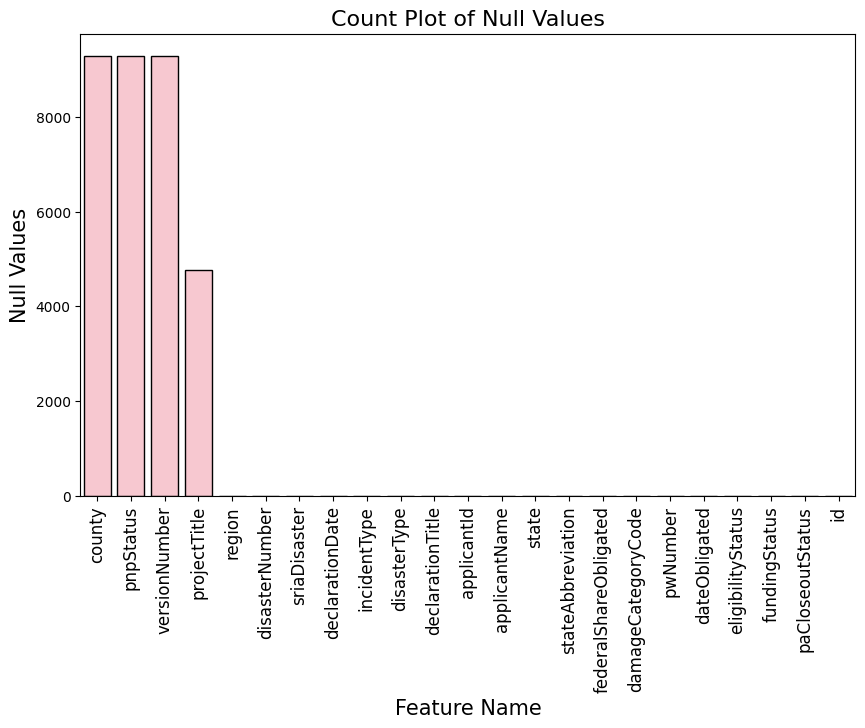

In [118]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=null_df,
    x='feature_name',
    y='null_values',
    edgecolor='black',
    color='pink'
)
ax.set_ylabel("Null Values", fontsize=15)
ax.set_xlabel("Feature Name", fontsize=15)
ax.set_title("Count Plot of Null Values", fontsize=16)
ax.tick_params(axis='x', labelrotation=90, labelsize=12)

plt.show()

📌 Null Value Distribution Across Metadata Fields

On analysis of missing values in the metadata columns reveals varying levels of null entries across different fields:

1. The county column contains 15,300 null values.

2. Both pnpStatus and versionNumber have 15,280 null values each.

3. The projectTitle column includes 7,495 null entries.

4. The federalShareObligated field has 87 null values, representing the lowest level of missingness among the listed columns.

The distribution shows that missing values are concentrated in specific metadata attributes, with administrative and categorical fields exhibiting substantially higher null counts compared to numerical fields. This pattern suggests inconsistency in metadata completeness across records.

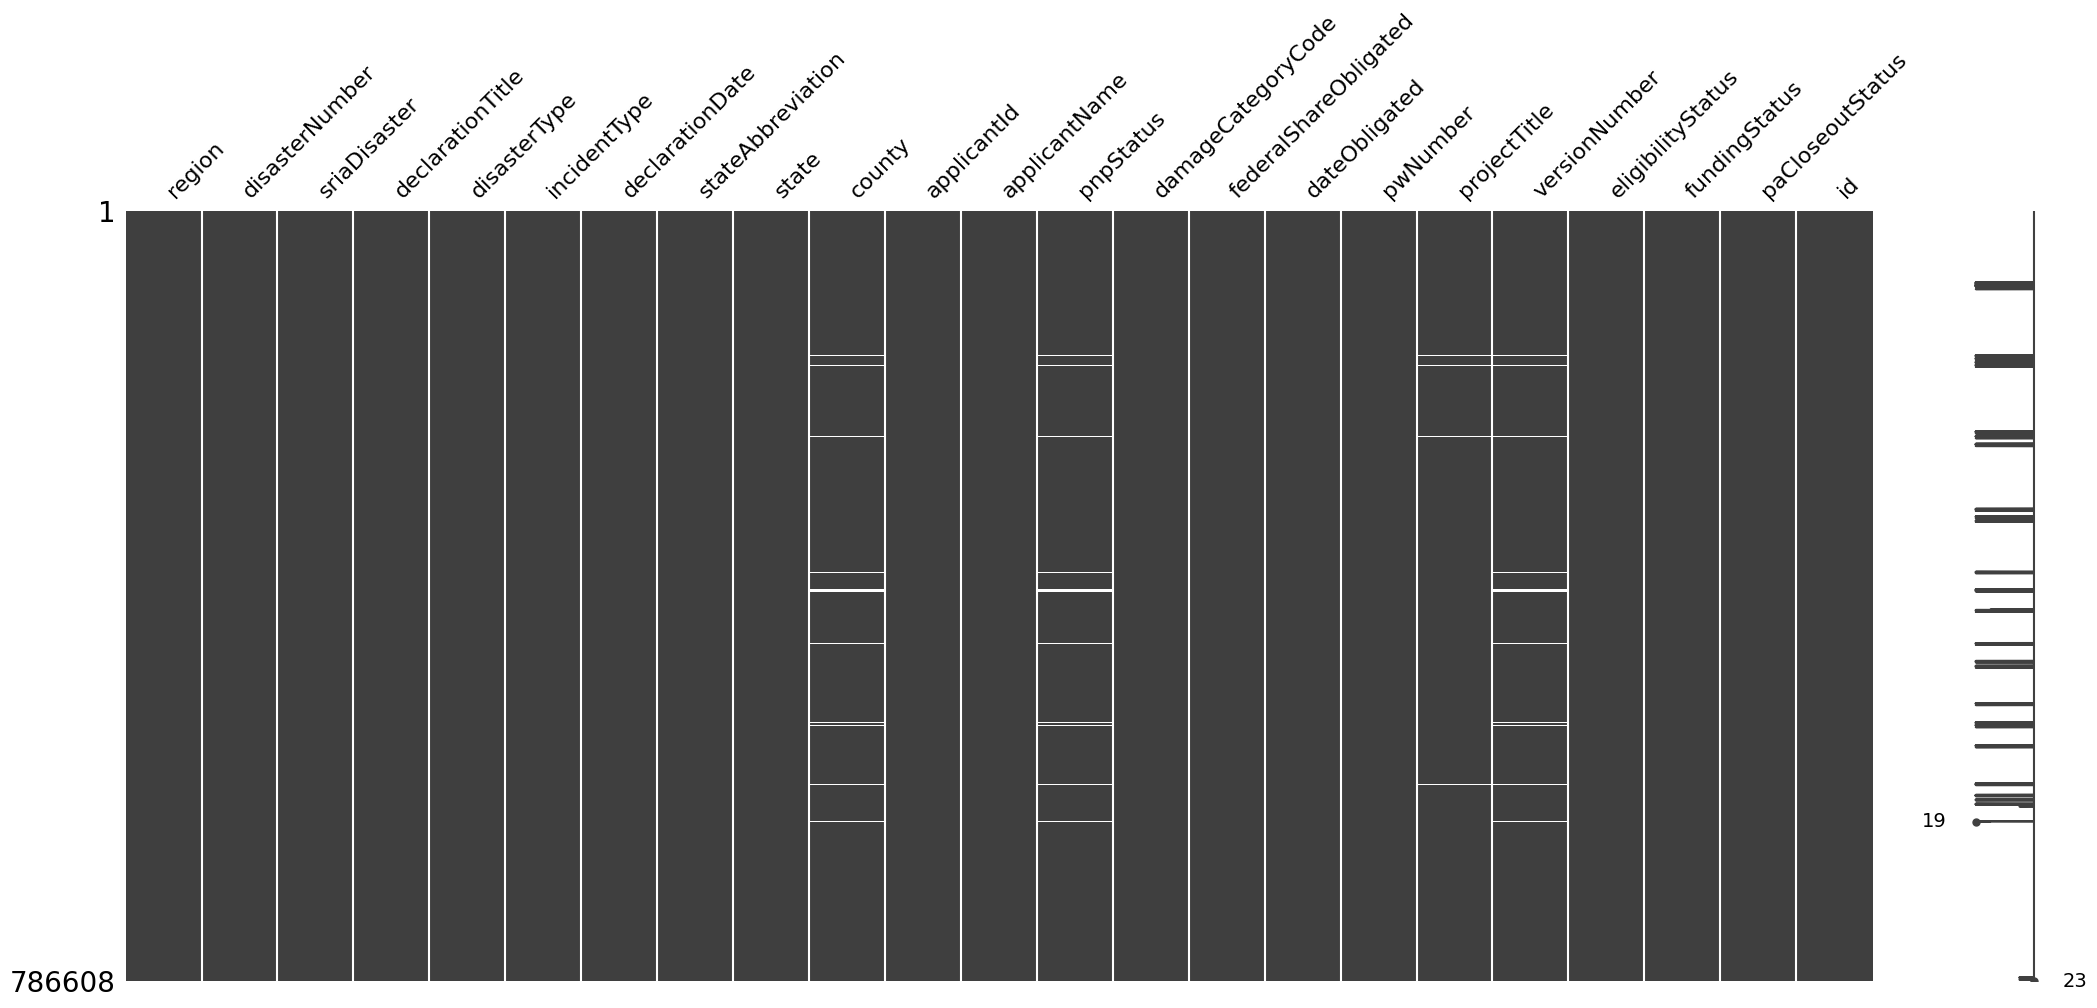

In [119]:
msno.matrix(
    df_clean,
    sparkline=True,
    label_rotation=45
)
plt.show()

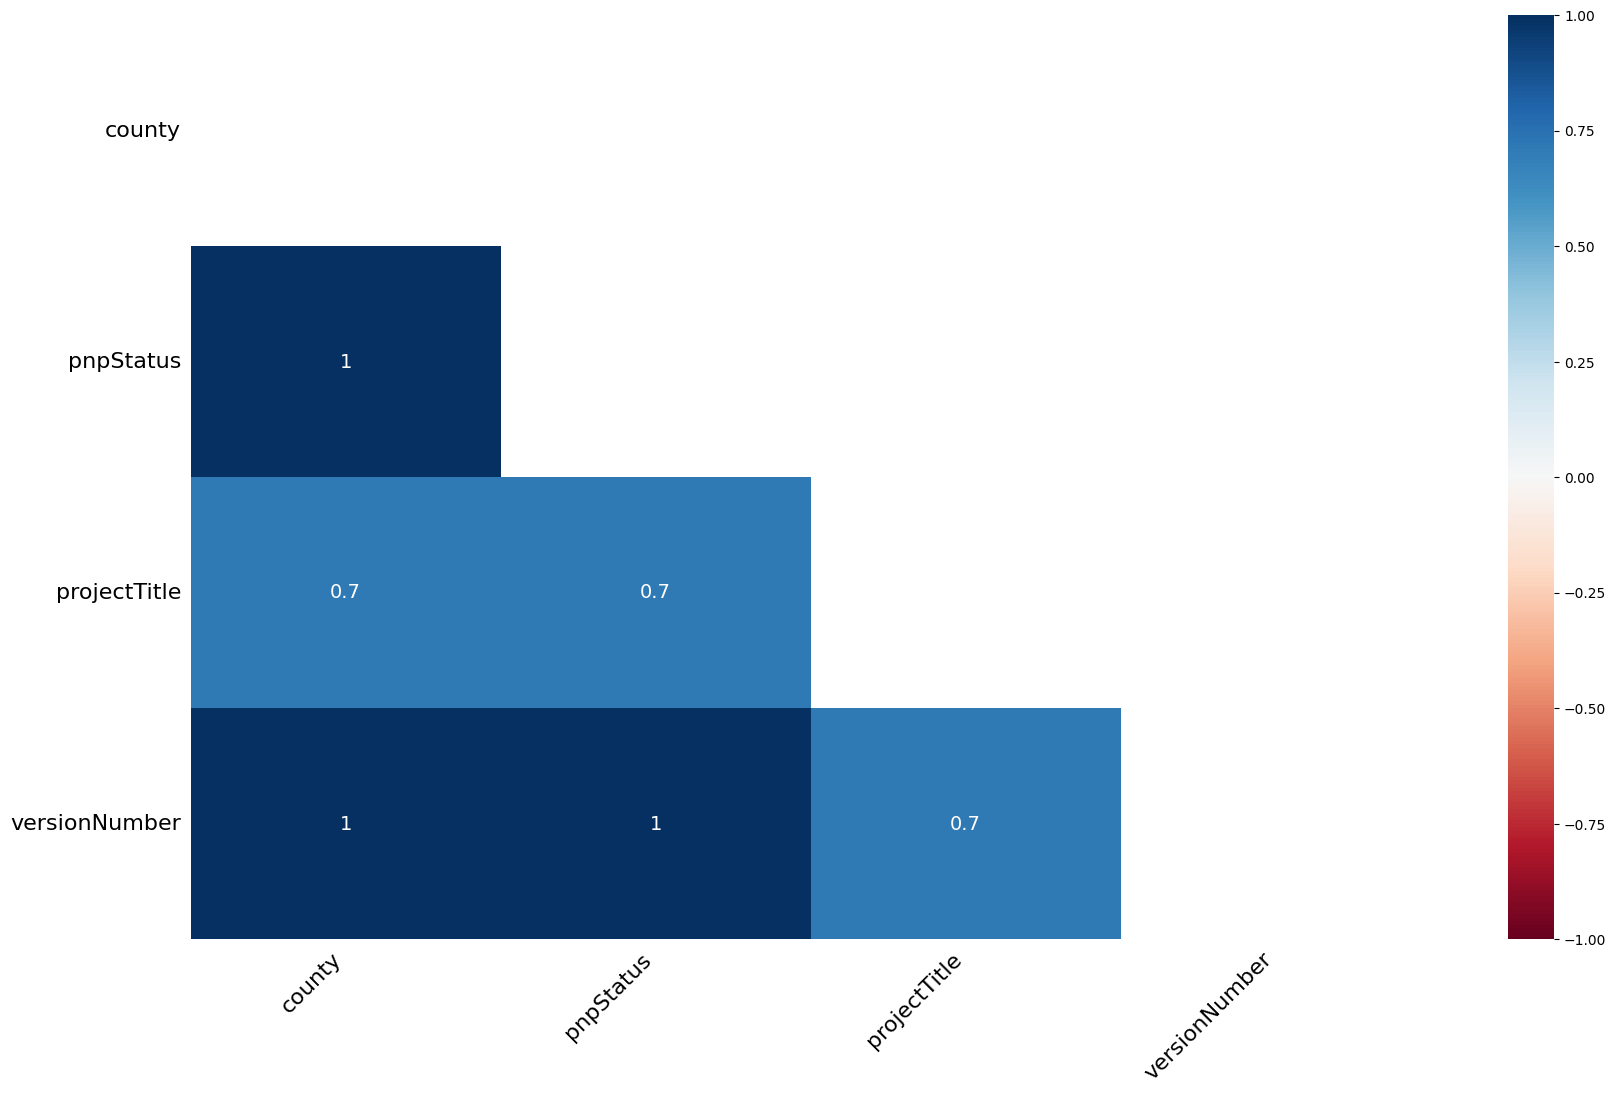

In [120]:
msno.heatmap(
    df_clean,
    label_rotation=45
)
plt.show()

📌 Correlation Structure in Missingness Patterns

The missingness heatmap reveals that null values across several metadata fields are strongly correlated rather than randomly distributed. Notably, the county, pnpStatus, and versionNumber columns exhibit near-perfect correlation in their missingness patterns, indicating that these fields tend to be missing simultaneously within the same records.

Additionally, the projectTitle column shows a moderate to strong correlation with these fields, suggesting partial overlap in missing entries. This implies that when administrative metadata such as county or status information is absent, descriptive fields like project titles are also frequently missing.

In contrast, the federalShareObligated column demonstrates very weak correlation with the other variables, indicating that its missing values occur more independently and are not strongly tied to the absence of other metadata fields.

Overall, the heatmap clearly indicates that missingness in this dataset follows a structured and clustered pattern, where groups of related columns tend to be missing together. This suggests that the null values are likely associated with systematic data collection or reporting gaps, rather than random omissions at the individual field level.

Correlation Structure and Type of Missingness

Based on this structured dependency—where the missingness of a variable is strongly associated with the observed values or missingness of other variables—the missing data mechanism aligns with Missing At Random (MAR). The observed correlations suggest that the probability of a value being missing depends on other recorded attributes, rather than on the unobserved value itself.

Overall, the heatmap demonstrates that missingness in this dataset is systematic and explainable, forming clear patterns across groups of related columns rather than occurring in a purely random manner.

In [121]:
df_clean.head(3)

,region,disasterNumber,sriaDisaster,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,pnpStatus,damageCategoryCode,federalShareObligated,dateObligated,pwNumber,projectTitle,versionNumber,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,9,1397,0,EARTHQUAKE,DR,Earthquake,2001-12-05T00:00:00.000Z,GU,Guam,Statewide,000-U6K9Y-00,GUAM WATERWORKS AUTHORITY,0.0,F - Public Utilities,121.50,2002-02-01T00:00:00.000Z,37,PUMP STATION REPAIR - HAIRLINE CRACKS,0.0,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
1,4,1381,0,TROPICAL STORM ALLISON,DR,Severe Storm,2001-06-17T00:00:00.000Z,FL,Florida,Washington,133-99133-00,WASHINGTON COUNTY,0.0,C - Roads and Bridges,3116.84,2001-10-03T00:00:00.000Z,210,ROADS AND BRIDGES,0.0,E,O,C,553d4c29-85ef-4002-ad7f-0b10c0b3da19
2,6,1709,0,"SEVERE STORMS, TORNADOES, AND FLOODING",DR,Severe Storm,2007-06-29T00:00:00.000Z,TX,Texas,Henderson,213-99213-00,HENDERSON (COUNTY),0.0,C - Roads and Bridges,7211.69,2007-11-09T00:00:00.000Z,2594,ROADS AND BRIDGES,0.0,E,O,C,743771d1-7292-4009-afc7-a8258ebc4414


In [122]:
# Fixing datatype of datetime cols
df_clean = df_clean.assign(
    dateObligated = pd.to_datetime(df_clean.dateObligated.str.split("T").str[0]),
    declarationDate = pd.to_datetime(df_clean.declarationDate.str.split("T").str[0])
)

### Feature Description

**1. region**: Identifies the FEMA administrative region responsible for overseeing the disaster response and recovery activities. FEMA divides the country into regions to manage operations more efficiently, and this field indicates which regional office handled coordination, approvals, and monitoring of projects and funding for a given disaster. It is useful for regional-level analysis, workload comparison, and understanding geographic variations in disaster management practices.

**2. disasterNumber**: A unique numeric identifier assigned by FEMA to each officially declared disaster. This number acts as the primary key linking all related records, including applications, project worksheets, funding obligations, and revisions. It enables tracking a disaster across time and datasets and is essential for aggregating impacts, costs, and recovery outcomes at the disaster-event level.

**3. sriaDisaster**: Indicates whether the disaster is covered under the Special Risk Insurance Act (SRIA). This flag affects insurance-related considerations and eligibility for certain types of federal assistance, especially in cases involving insurable properties. It helps distinguish disasters with additional regulatory or insurance constraints from standard disaster declarations.

**4. pnpStatus**: Specifies whether the applicant is a Public entity or a Private Non-Profit (PNP) organization. This classification directly influences eligibility criteria, documentation requirements, and cost-sharing rules under FEMA’s Public Assistance program. It is important for analyzing differences in funding patterns, approval timelines, and recovery outcomes between public agencies and non-profit organizations.

**5. federalShareObligated**: Represents the actual amount of federal funding that has been formally obligated for a specific project or work item. This is a key financial variable, reflecting confirmed government spending rather than estimated costs. It is critical for expenditure analysis, budget monitoring, and assessing the financial impact of disasters across regions, disaster types, or applicant categories.

**6. pwNumber**: Stands for Project Worksheet Number and uniquely identifies individual damage, repair, or recovery projects within a disaster. Each project worksheet documents the scope of work, estimated costs, approvals, and funding decisions. This column allows granular analysis at the project level, such as cost distribution, project complexity, and approval frequency within a single disaster.

**7. versionNumber**: Indicates the revision number of a project worksheet, capturing how many times the project details, scope, or cost estimates have been updated after initial submission. Higher version numbers often reflect project changes, reassessments, or corrections over time, making this field valuable for audit trails, change tracking, and understanding how recovery projects evolve during the disaster response lifecycle.

**8. declarationTitle**: Describes the official title of the disaster declaration as issued by FEMA, typically summarizing the nature, location, or scope of the event. This field provides contextual information about the disaster and is useful for grouping similar events, validating disaster metadata, and improving interpretability when presenting or reporting results.

**9. disasterType**: Indicates the type of FEMA disaster declaration (for example, major disaster, emergency, or fire management assistance). This classification determines the level of federal involvement, available assistance programs, and overall funding mechanisms, making it important for policy-level analysis and comparison across disaster responses.

**10. incidentType**: Specifies the underlying hazard or cause of the disaster, such as flood, hurricane, wildfire, earthquake, or severe storm. This column is critical for hazard-based analysis, allowing comparison of impacts, costs, and recovery patterns across different types of incidents.

**11. stateAbbreviation**: Contains the standard two-letter abbreviation of the U.S. state in which the disaster or project is located. This provides a compact geographic identifier that is useful for joins, filtering, and aggregation in analytical workflows.

**12. state**: Stores the full name of the state associated with the disaster or project. It offers a more readable geographic reference and is commonly used for reporting, visualization, and state-level impact analysis.

**13. county**: Identifies the county in which the applicant or project is located. This enables fine-grained geographic analysis, such as county-level damage assessment, funding distribution, and localized disaster impact studies.

**14. applicantId**: A unique identifier assigned to each applicant within FEMA’s Public Assistance program. This field allows consistent tracking of an entity across multiple disasters or projects and is essential for applicant-level aggregation, history analysis, and deduplication.

**15. applicantName**: The official name of the applying entity, such as a local government, state agency, or private non-profit organization. This column adds human-readable context and is useful for validation, reporting, and identifying major recipients of federal assistance.

**16. damageCategoryCode**: Represents the FEMA damage category under which the project falls (such as debris removal, emergency protective measures, or permanent work categories). This classification is central to understanding the nature of the work performed and supports analysis of cost distribution across different types of disaster-related activities.

**17. projectTitle**: Provides a short descriptive title summarizing the scope or purpose of the project worksheet. It often reflects the type of damage or recovery activity and can be used for qualitative analysis, text-based exploration, or project categorization.

**18. eligibilityStatus**: Indicates whether the project or applicant has been deemed eligible for federal assistance based on FEMA guidelines. This field is important for understanding approval rates, rejection patterns, and compliance with program requirements.

**19. fundingStatus**: Reflects the current stage of funding for the project, such as pending, approved, obligated, or denied. It helps track progress through the funding lifecycle and is useful for monitoring delays, bottlenecks, or completion rates.

**20. paCloseoutStatus**: Denotes whether the Public Assistance (PA) project has been formally closed out, meaning all work has been completed, costs reconciled, and documentation finalized. This status is critical for lifecycle analysis and identifying ongoing versus completed recovery efforts.

**21. id**: A system-generated unique identifier for each record in the dataset. This column serves as a technical primary key, ensuring record-level uniqueness and enabling reliable joins, indexing, and traceability within and across datasets.

---
# <span style="color:Orange">Univariate Analysis</span>

### Continuous Features

In [123]:
df_clean.head(3)

,region,disasterNumber,sriaDisaster,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,pnpStatus,damageCategoryCode,federalShareObligated,dateObligated,pwNumber,projectTitle,versionNumber,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,9,1397,0,EARTHQUAKE,DR,Earthquake,2001-12-05,GU,Guam,Statewide,000-U6K9Y-00,GUAM WATERWORKS AUTHORITY,0.0,F - Public Utilities,121.50,2002-02-01,37,PUMP STATION REPAIR - HAIRLINE CRACKS,0.0,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
1,4,1381,0,TROPICAL STORM ALLISON,DR,Severe Storm,2001-06-17,FL,Florida,Washington,133-99133-00,WASHINGTON COUNTY,0.0,C - Roads and Bridges,3116.84,2001-10-03,210,ROADS AND BRIDGES,0.0,E,O,C,553d4c29-85ef-4002-ad7f-0b10c0b3da19
2,6,1709,0,"SEVERE STORMS, TORNADOES, AND FLOODING",DR,Severe Storm,2007-06-29,TX,Texas,Henderson,213-99213-00,HENDERSON (COUNTY),0.0,C - Roads and Bridges,7211.69,2007-11-09,2594,ROADS AND BRIDGES,0.0,E,O,C,743771d1-7292-4009-afc7-a8258ebc4414


In [124]:
discrete_features = [
    'region',
    'declarationTitle',
    'disasterType',
    'incidentType',
    'stateAbbreviation',
    'state',
    'county',
    'pnpStatus',
    'damageCategoryCode',
    'projectTitle',
    'eligibilityStatus',
    'fundingStatus',
    'paCloseoutStatus'
]

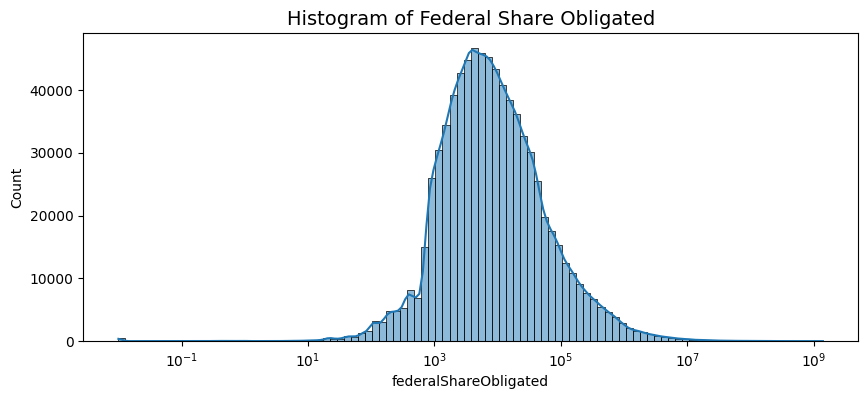

In [125]:
plt.figure(figsize=(10,4))
sns.histplot(
    data=df_clean,
    x='federalShareObligated',
    bins=100,
    log_scale=True,
    kde=True
)
plt.title("Histogram of Federal Share Obligated", fontsize=14)
plt.show()

### Categorical Features

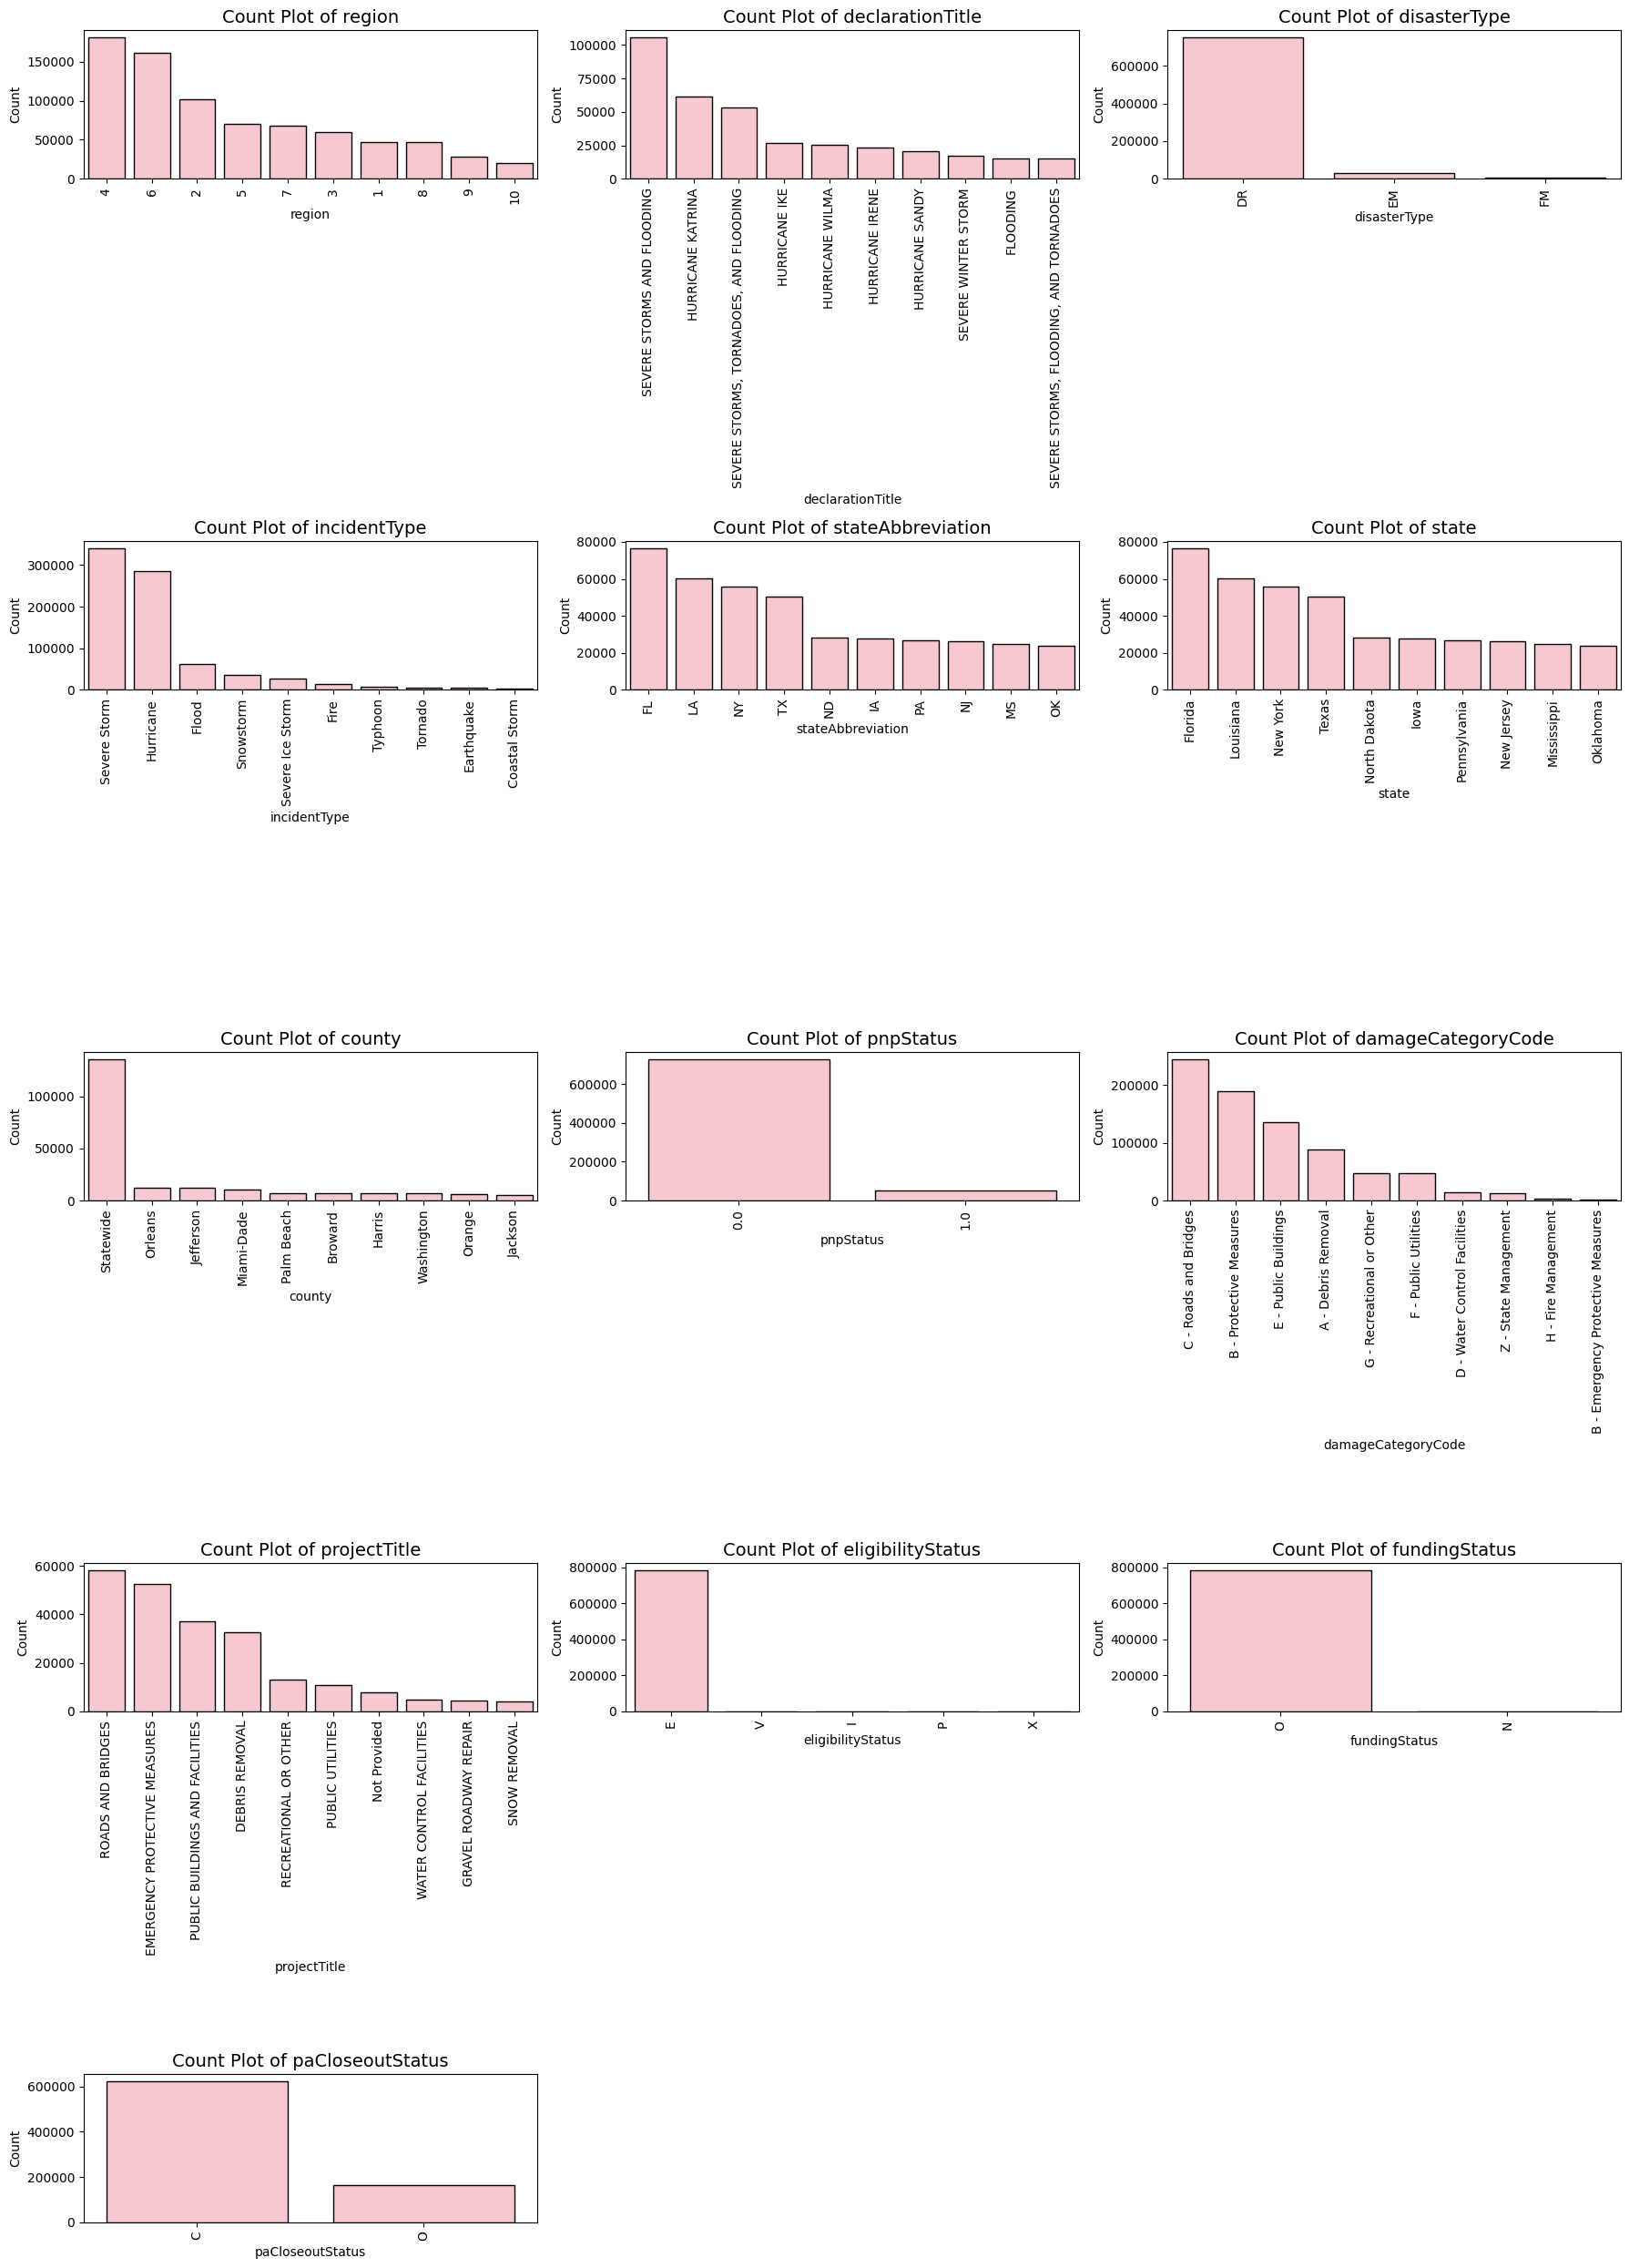

In [126]:
n_cols = 3
n_rows = math.ceil(len(discrete_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, discrete_features):

    top_categories = (
        df_clean[col]
        .value_counts(dropna=True)
        .nlargest(10)
        .index
    )

    plot_data = df_clean[col].where(df_clean[col].isin(top_categories))

    sns.countplot(
        x=plot_data,
        ax=ax,
        order=plot_data.value_counts().index,
        color="pink",
        edgecolor="black"
    )

    ax.set_title(f"Count Plot of {col}", fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(discrete_features):]:
    ax.remove()

plt.tight_layout()
plt.show()

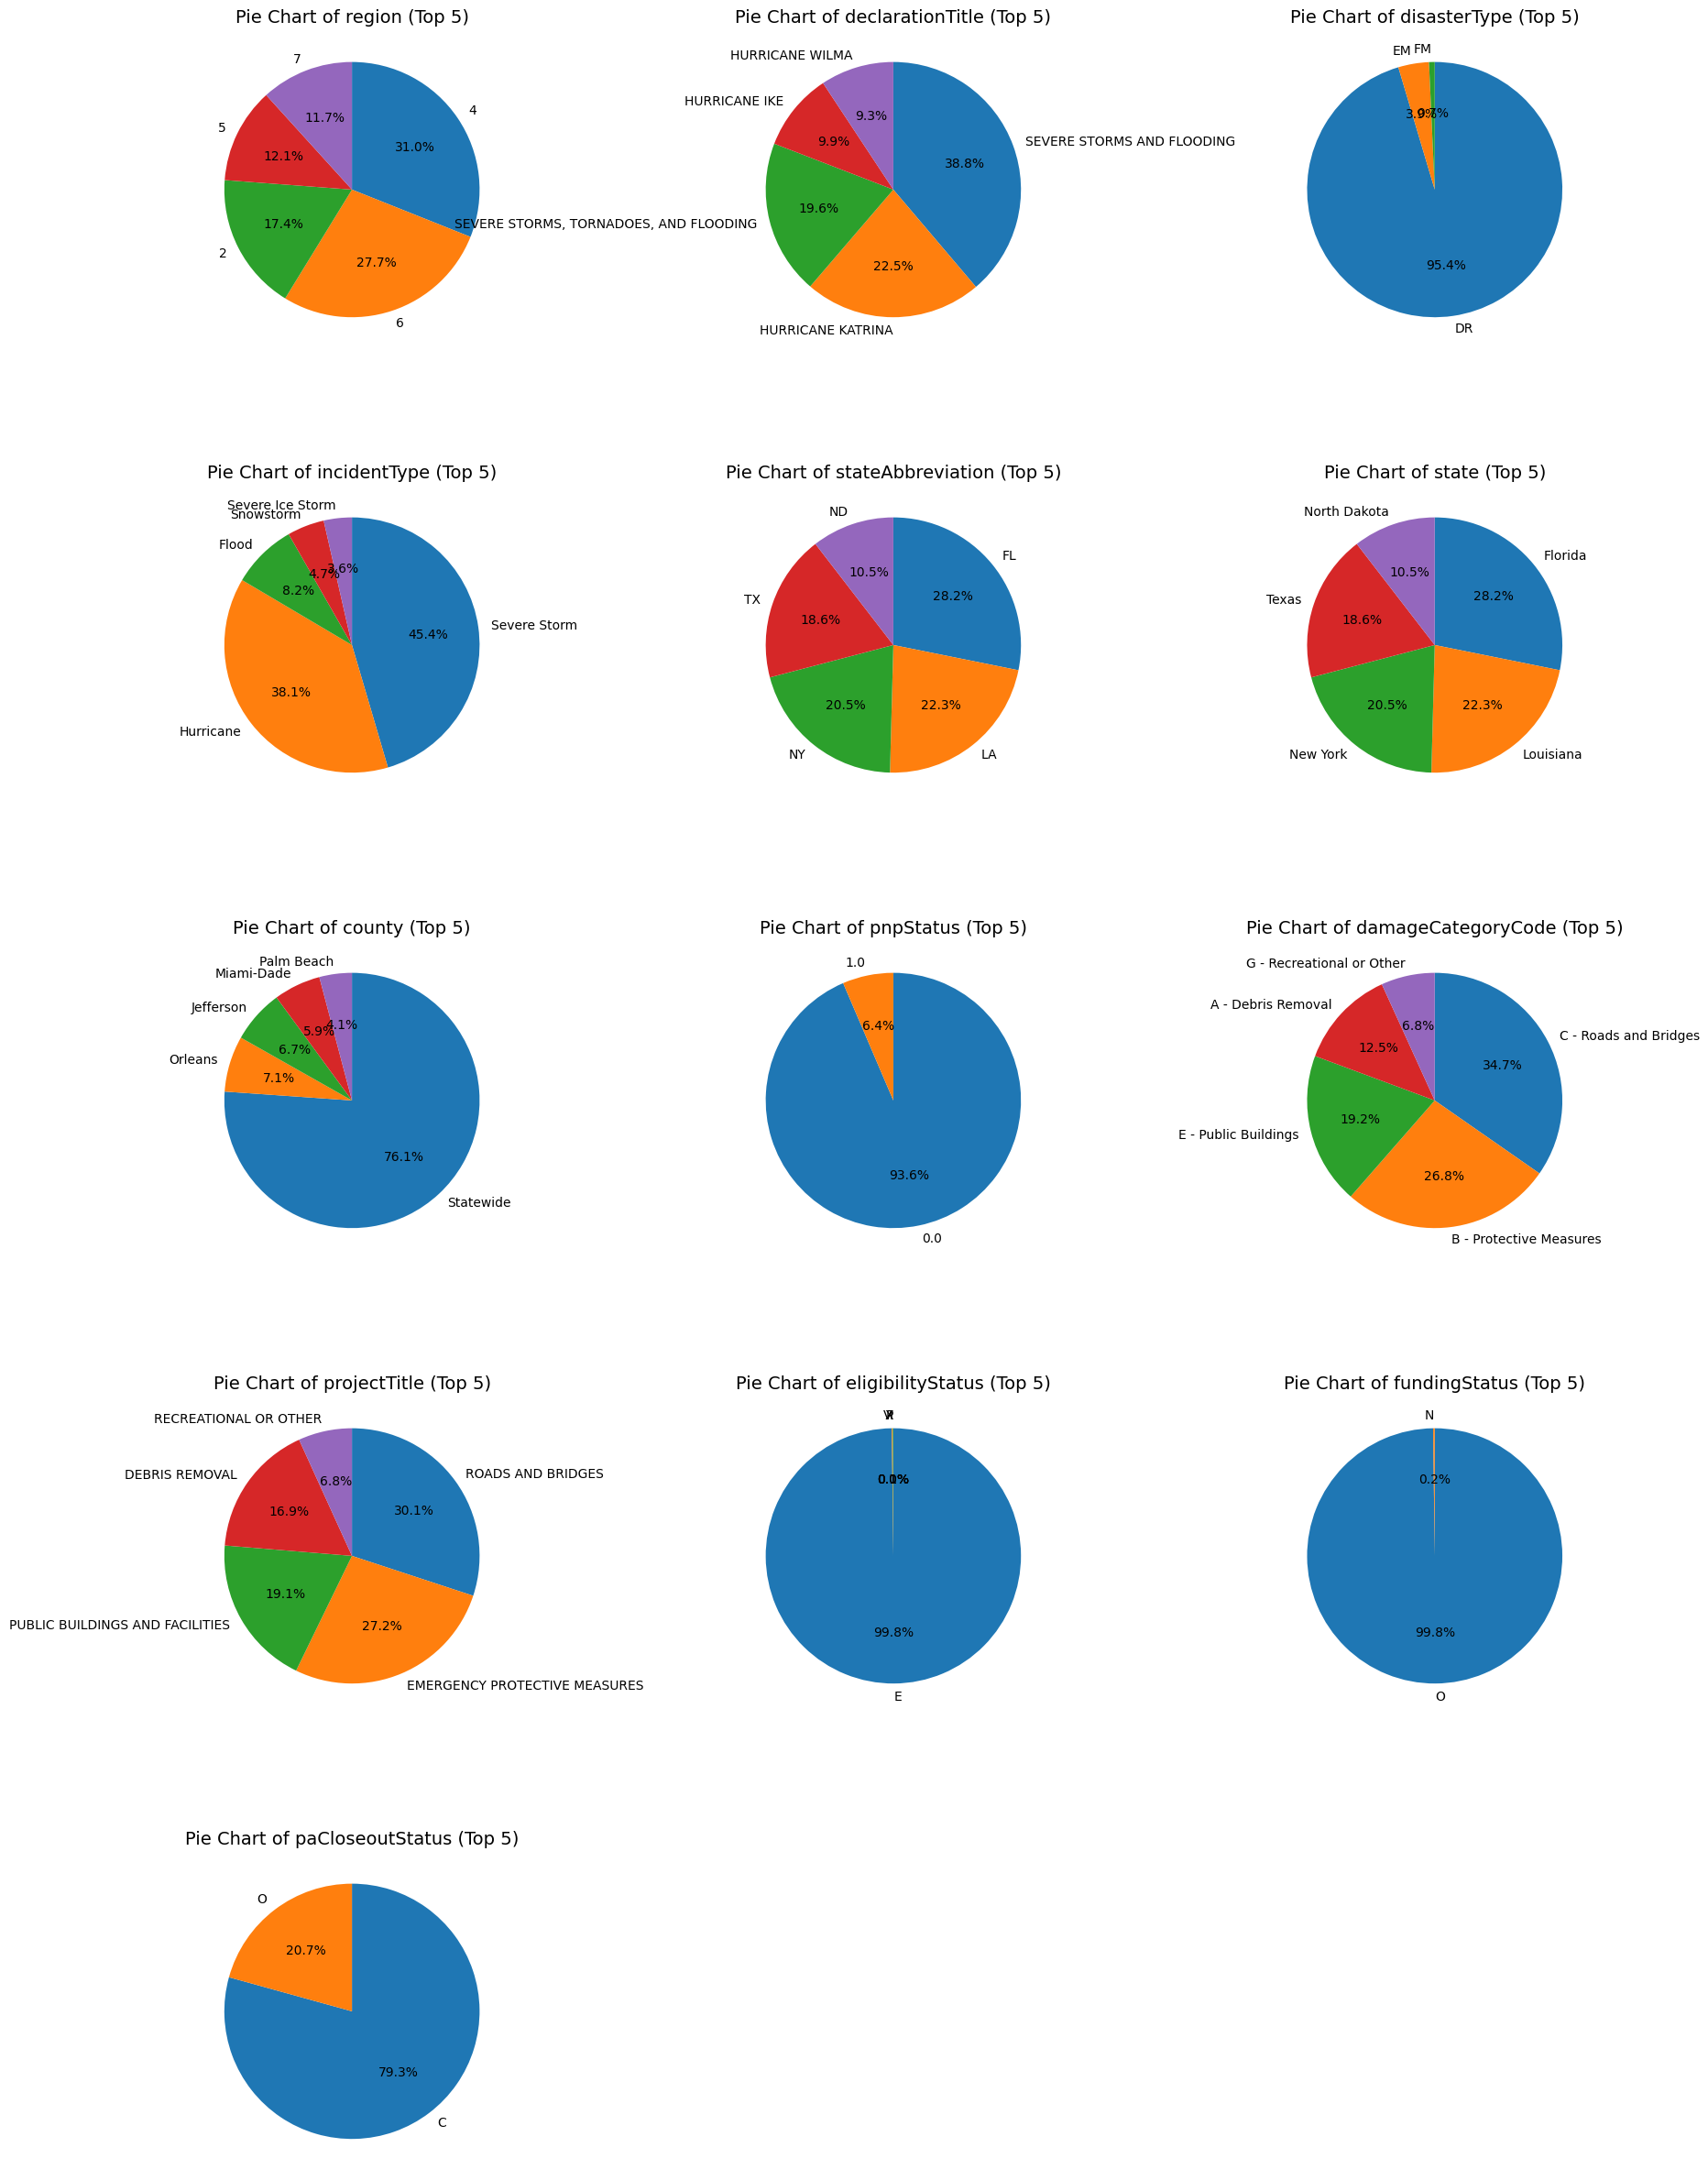

In [127]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, discrete_features):

    value_counts = (
        df_clean[col]
        .value_counts(dropna=True)
        .nlargest(5)
    )

    ax.pie(
        value_counts.values,
        labels=value_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False
    )

    ax.set_title(f"Pie Chart of {col} (Top 5)", fontsize=14)

# Remove unused subplots
for ax in axes[len(discrete_features):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [128]:
high_cardinality_cat_features=[
    'declarationTitle',
    'incidentType',
    'state',
    'county',
    'applicantName',
    'damageCategoryCode',
    'projectTitle'
]

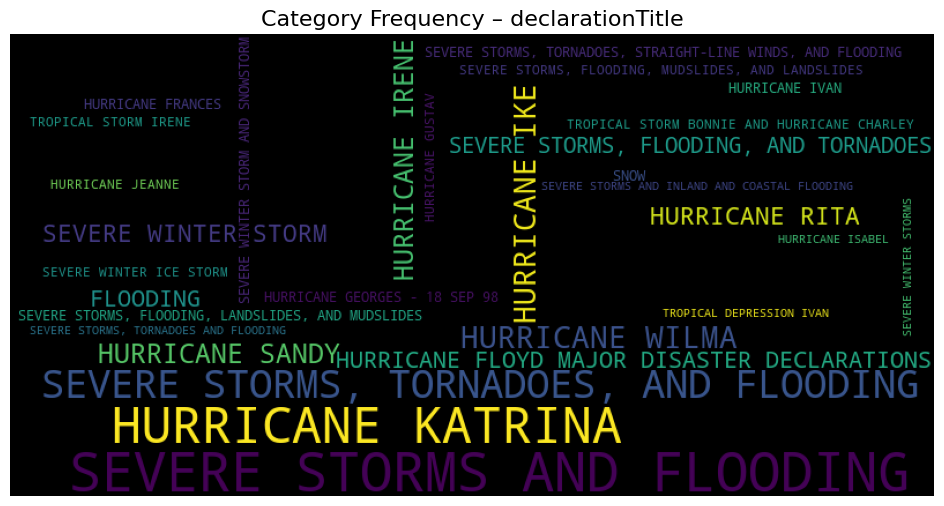

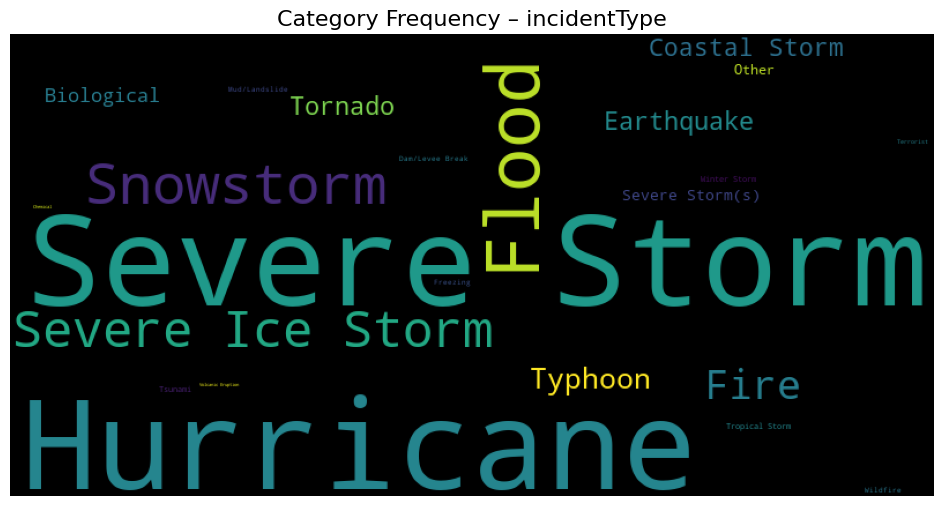

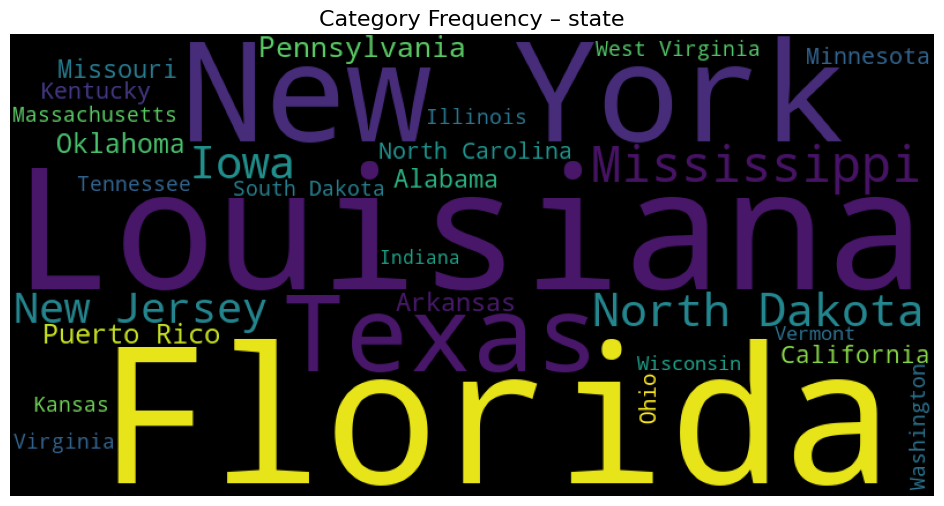

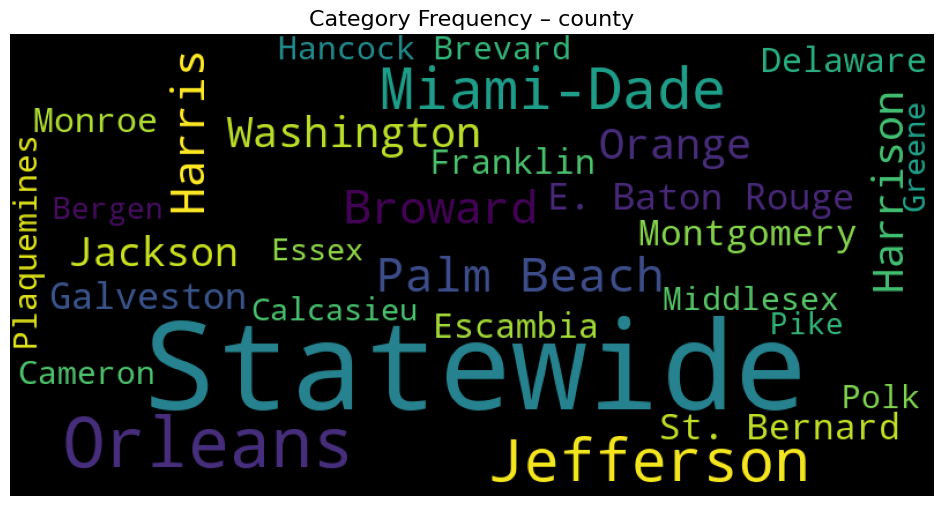

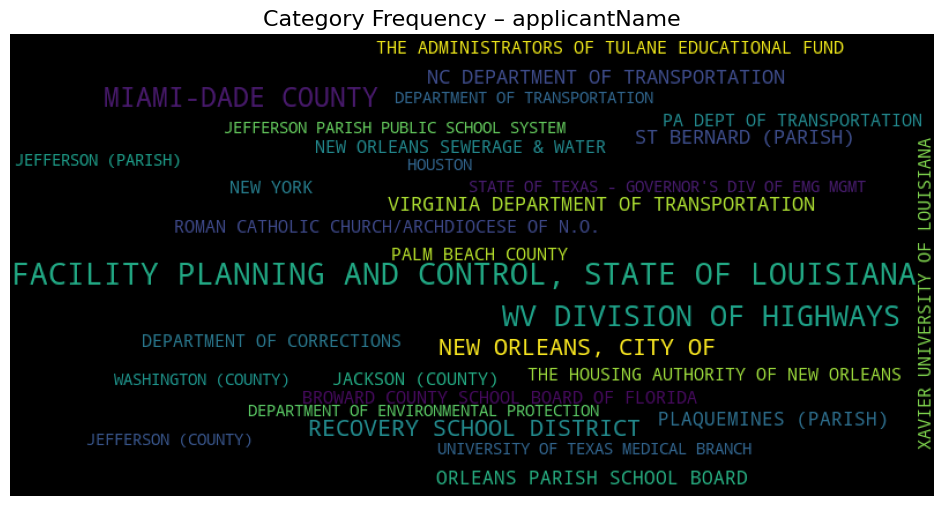

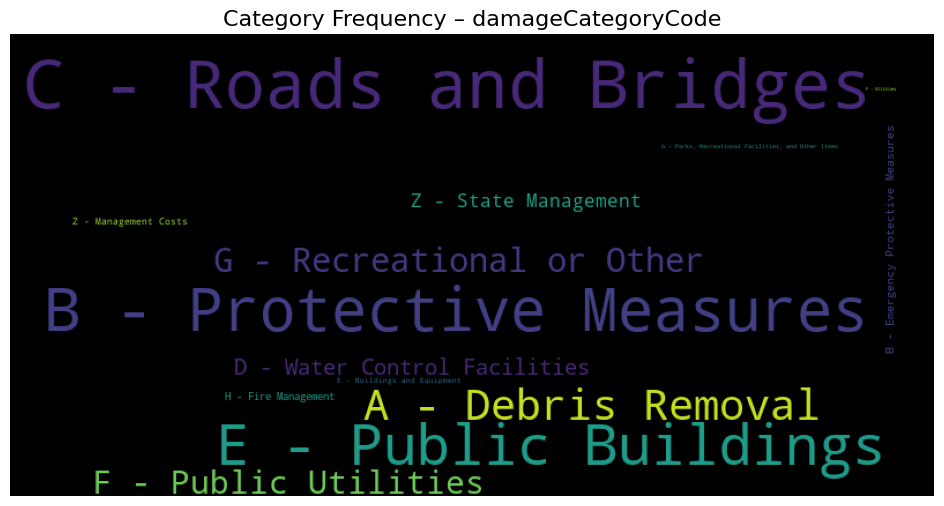

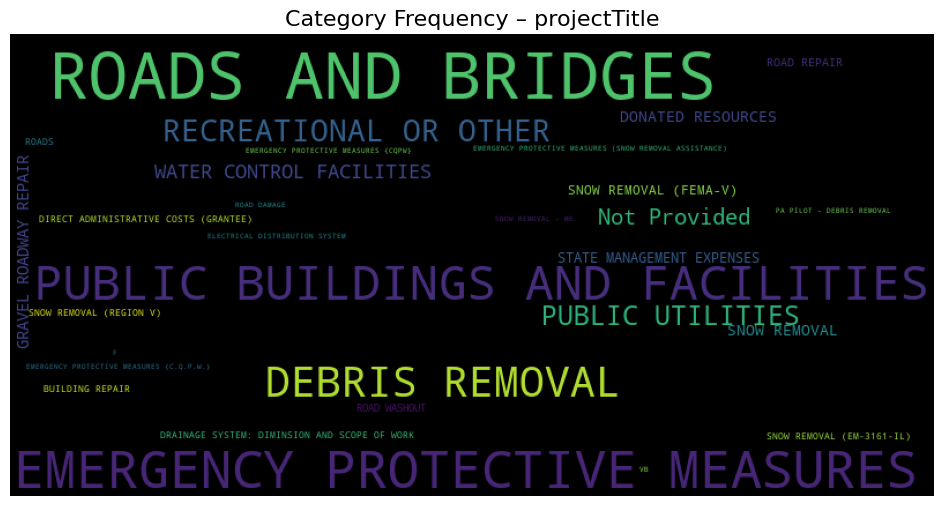

In [129]:
for col in high_cardinality_cat_features:
    freqs = (
        df[col]
        .dropna()
        .astype(str)
        .value_counts()
        .to_dict()
    )

    wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        max_words=30
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f"Category Frequency – {col}", fontsize=16)
    plt.show()

# <span style="color:Orange">BI-Variate Analysis</span>
---

1. **Declaration Date**

The declarationDate represents the point at which a disaster is officially declared by FEMA, triggering federal involvement. This date is closely tied to the disaster event itself or its immediate aftermath. It marks when a state’s request for assistance is approved and when various forms of federal aid become authorized.

2. **Date Obligated**

The dateObligated represents the date on which FEMA formally committed federal funds to a specific Public Assistance project. This occurs after the disaster has been declared and after the project has been reviewed for eligibility, scope, and estimated cost. In many cases, the obligation date can be weeks or even months later than the declaration date.

In [156]:
df_clean.head(3)

,region,disasterNumber,sriaDisaster,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,pnpStatus,damageCategoryCode,federalShareObligated,dateObligated,pwNumber,projectTitle,versionNumber,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,9,1397,0,EARTHQUAKE,DR,Earthquake,2001-12-05,GU,Guam,Statewide,000-U6K9Y-00,GUAM WATERWORKS AUTHORITY,0.0,F - Public Utilities,121.50,2002-02-01,37,PUMP STATION REPAIR - HAIRLINE CRACKS,0.0,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
1,4,1381,0,TROPICAL STORM ALLISON,DR,Severe Storm,2001-06-17,FL,Florida,Washington,133-99133-00,WASHINGTON COUNTY,0.0,C - Roads and Bridges,3116.84,2001-10-03,210,ROADS AND BRIDGES,0.0,E,O,C,553d4c29-85ef-4002-ad7f-0b10c0b3da19
2,6,1709,0,"SEVERE STORMS, TORNADOES, AND FLOODING",DR,Severe Storm,2007-06-29,TX,Texas,Henderson,213-99213-00,HENDERSON (COUNTY),0.0,C - Roads and Bridges,7211.69,2007-11-09,2594,ROADS AND BRIDGES,0.0,E,O,C,743771d1-7292-4009-afc7-a8258ebc4414


**Declaration Date**

The declarationDate represents the point at which a disaster is officially declared by FEMA, triggering federal involvement. This date is closely tied to the disaster event itself or its immediate aftermath. It marks when a state’s request for assistance is approved and when various forms of federal aid become authorized.

**Date Obligated**

The dateObligated represents the date on which FEMA formally committed federal funds to a specific Public Assistance project. This occurs after the disaster has been declared and after the project has been reviewed for eligibility, scope, and estimated cost. In many cases, the obligation date can be weeks or even months later than the declaration date.

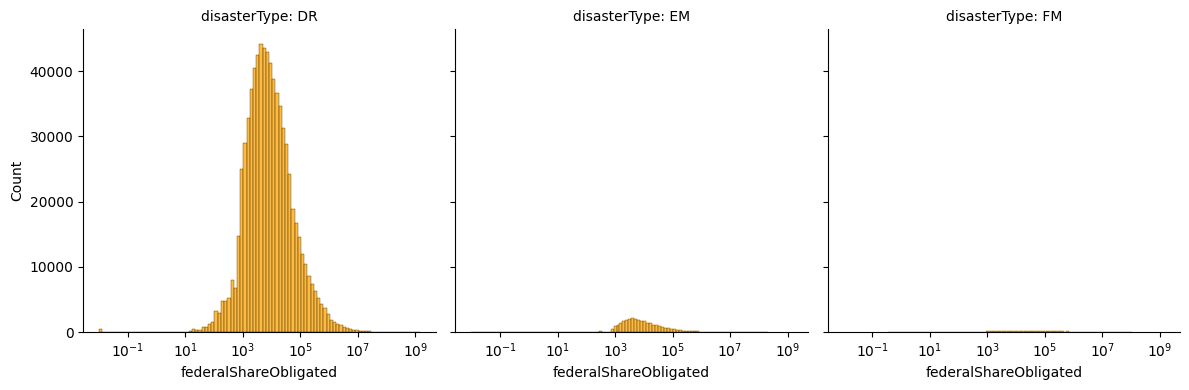

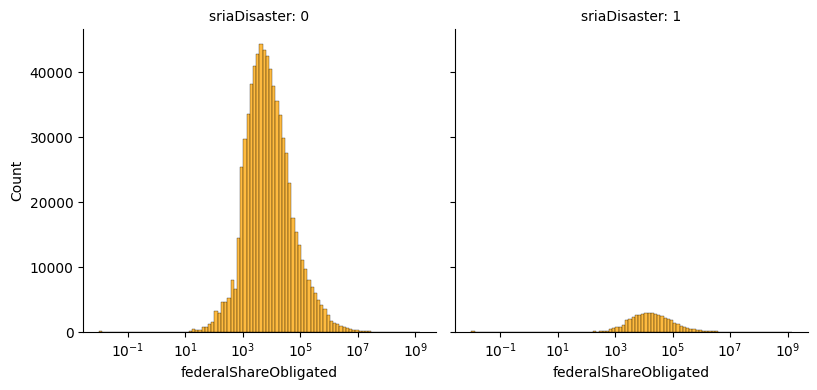

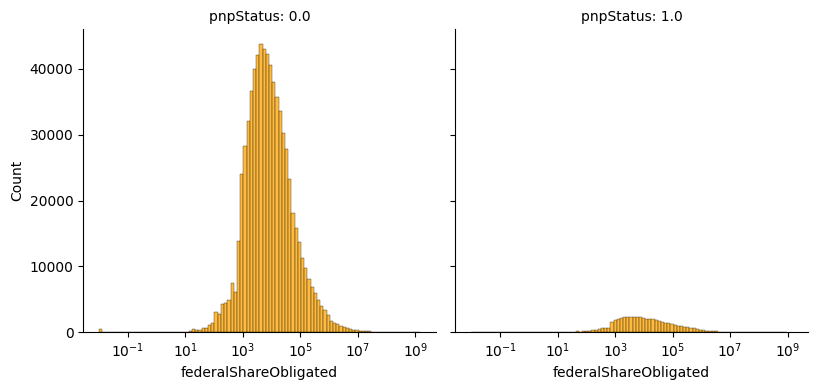

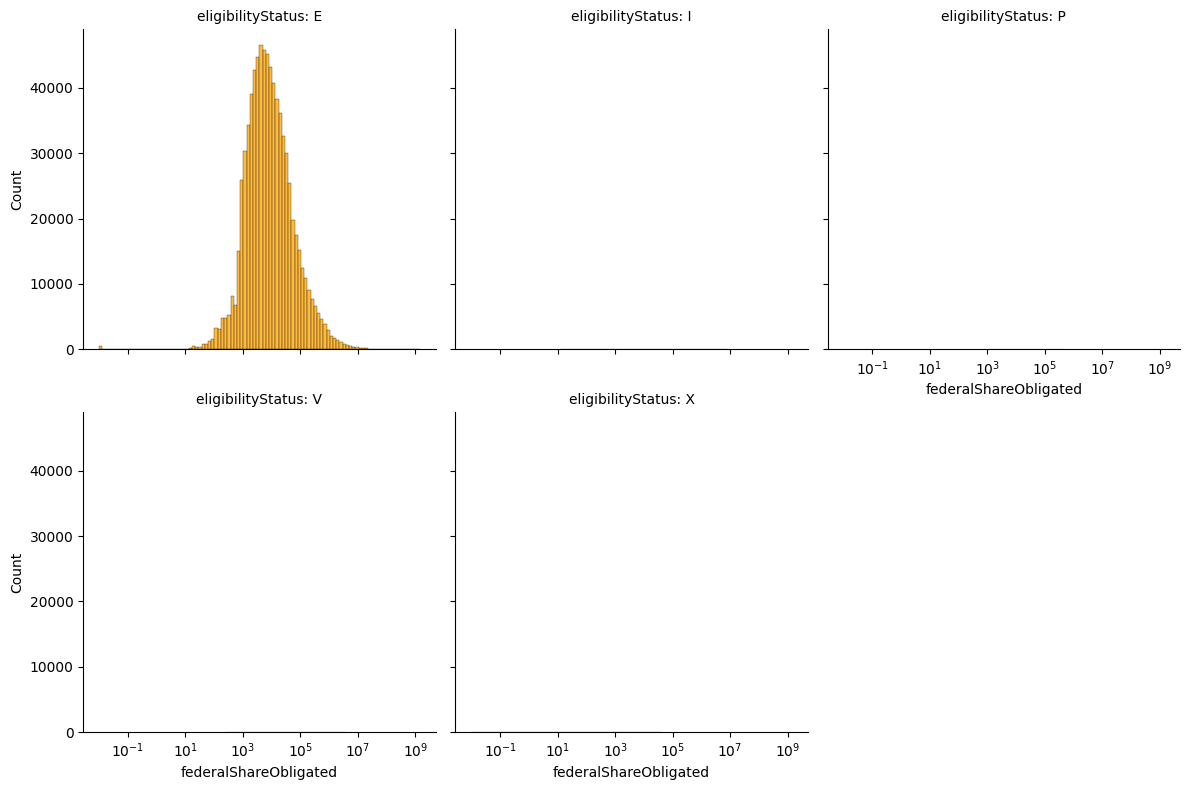

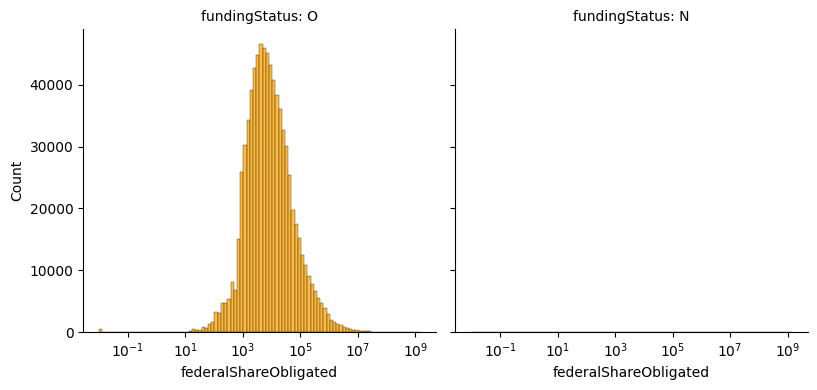

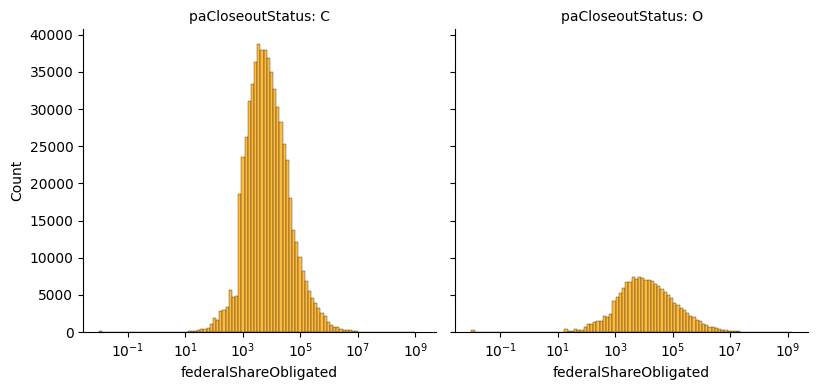

In [157]:
for col in ['disasterType', 'sriaDisaster', 'pnpStatus', 'eligibilityStatus','fundingStatus','paCloseoutStatus']:
    g = sns.FacetGrid(
        df_clean,
        col=col,
        col_wrap=3,
        height=4
    )

    g.map(sns.histplot, "federalShareObligated", log_scale=True, bins=100, color='orange')
    g.set_titles(col_template=f"{col}: {{col_name}}")
plt.show()

In [158]:
# Unique Applicants per Declaration Date

df_applicants_ts = (
    df_clean
    .groupby("declarationDate", as_index=False)["applicantId"]
    .nunique()
    .sort_values("declarationDate")
)

fig = px.line(
    df_applicants_ts,
    x="declarationDate",
    y="applicantId",
    title="Unique Applicants per Declaration Date",
    labels={
        "declarationDate": "Declaration Date",
        "applicantId": "Number of Unique Applicants"
    }
)

fig.update_layout(
    width=1000,
    height=400,
    title=dict(font=dict(size=18)),
    xaxis=dict(
        title_font=dict(size=16),
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title_font=dict(size=16),
        tickfont=dict(size=12)
    )
)

fig.update_xaxes(
    tickangle=45,
    rangeslider_visible=True
)


fig.show()

Disaster Type vs Federal Share Obligated: Plot type: Box plot (Categorical × Numerical)

This plot is used to compare how federal funding varies across different disaster types. Since disaster-related costs are highly skewed, a box plot with a log scale allows meaningful comparison of distributions and highlights extreme high-cost events.

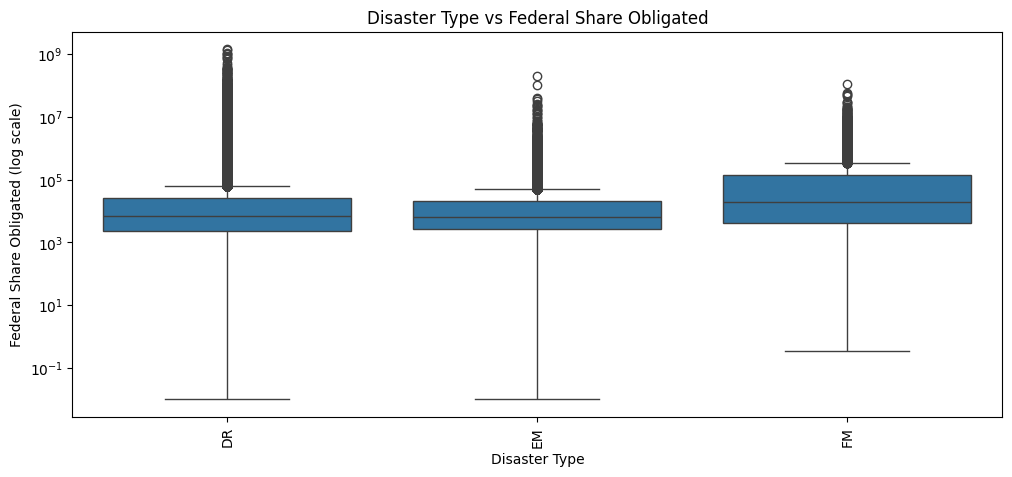

In [159]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=df_clean,
    x="disasterType",
    y="federalShareObligated"
)

plt.yscale("log")
plt.xticks(rotation=90)
plt.xlabel("Disaster Type")
plt.ylabel("Federal Share Obligated (log scale)")
plt.title("Disaster Type vs Federal Share Obligated")
plt.show()


State vs Federal Share Obligated (Top 10 States): Plot type: Box plot (Categorical × Numerical)

States differ in geography, disaster exposure, and infrastructure. Limiting the analysis to the top states by frequency avoids clutter while allowing regional comparison of funding distributions.

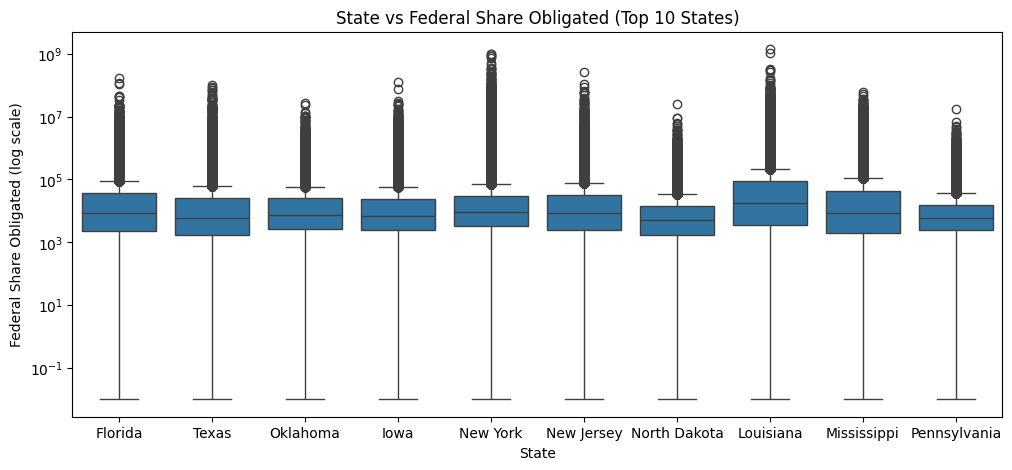

In [160]:
top_states = df_clean["state"].value_counts().nlargest(10).index

plt.figure(figsize=(12, 5))

sns.boxplot(
    data=df_clean[df_clean["state"].isin(top_states)],
    x="state",
    y="federalShareObligated"
)

plt.yscale("log")
plt.xlabel("State")
plt.ylabel("Federal Share Obligated (log scale)")
plt.title("State vs Federal Share Obligated (Top 10 States)")
plt.show()


Damage Category Code vs Federal Share Obligated: Plot type: Box plot (Categorical × Numerical)

Damage category codes represent different types or levels of damage. Comparing them against federal funding helps evaluate whether higher damage categories are associated with higher costs.

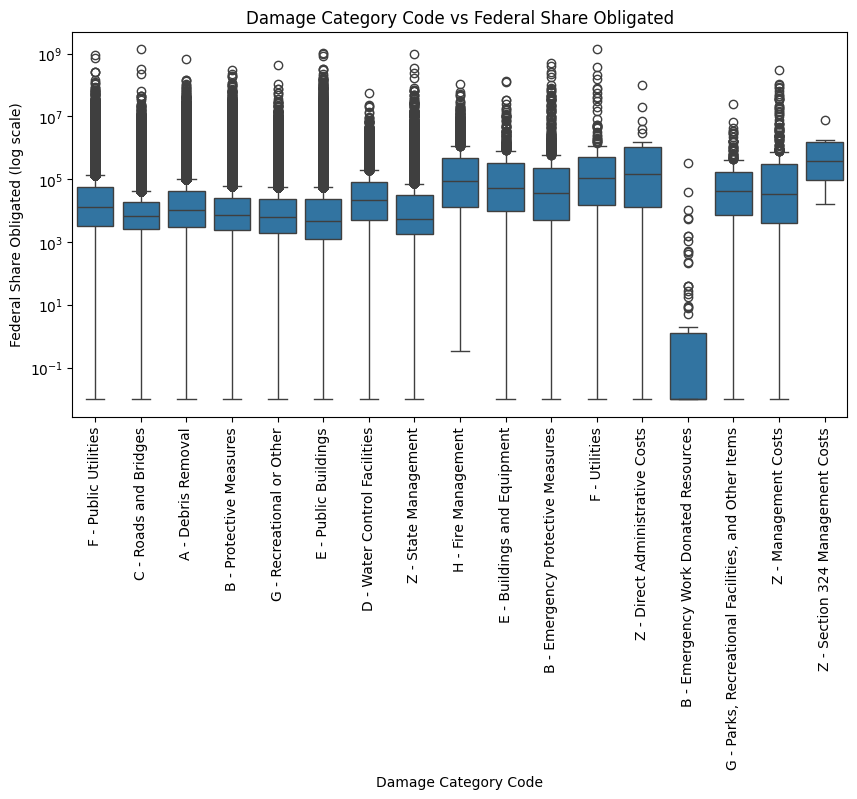

In [161]:
plt.figure(figsize=(10, 5))

sns.boxplot(
    data=df_clean,
    x="damageCategoryCode",
    y="federalShareObligated"
)

plt.yscale("log")
plt.xlabel("Damage Category Code")
plt.ylabel("Federal Share Obligated (log scale)")
plt.title("Damage Category Code vs Federal Share Obligated")
plt.xticks(rotation=90)
plt.show()

Eligibility Status vs Funding Status: Plot type: Heatmap (Categorical × Categorical)

This plot is used to analyze the relationship between project eligibility and funding outcomes. A heatmap clearly shows how funding status varies across eligibility categories.

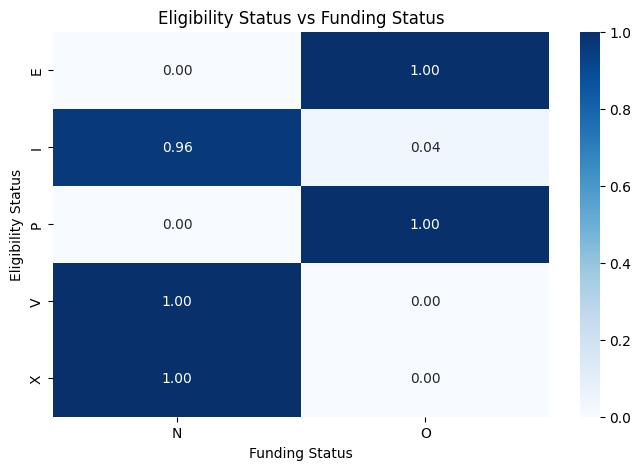

In [162]:
ct = pd.crosstab(
    df_clean["eligibilityStatus"],
    df_clean["fundingStatus"],
    normalize="index"
)

plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt=".2f", cmap="Blues")

plt.xlabel("Funding Status")
plt.ylabel("Eligibility Status")
plt.title("Eligibility Status vs Funding Status")
plt.show()

This aggregation summarizes federal disaster funding by incident type, capturing both the scale and distribution of financial impact across different kinds of incidents. By reporting the count, median, maximum, and total federal obligation for each incident type, it provides a balanced view of frequency, typical cost, extreme cases, and overall contribution to spending.

The count indicates how frequently each incident type occurs, which is critical for interpreting the other metrics and avoiding conclusions driven by rare events. The median represents the typical funding amount and is less sensitive to extreme outliers, making it more reliable than the mean for highly skewed disaster cost data. The maximum highlights rare but catastrophic incidents that can significantly strain federal resources. The total obligation captures the cumulative financial burden of each incident type and identifies which incidents drive the largest share of overall federal spending.

Together, these metrics distinguish incident types that are frequent but low-cost from those that are rare but extremely expensive, as well as those that combine high frequency with high cumulative cost. This insight is particularly useful for identifying dominant cost drivers, understanding budgeting risk, and prioritizing incident types for deeper analysis or predictive modeling.

In [163]:
df_clean.groupby("incidentType")["federalShareObligated"].agg(
    count="count",
    median="median",
    max="max",
    total="sum"
)

,count,median,max,total
incidentType,,,,
Biological,613,51615.460,5.101072e+08,2.973322e+09
Chemical,55,8361.280,2.886012e+05,1.639099e+06
Coastal Storm,3415,12023.510,2.047140e+07,6.759378e+08
Dam/Levee Break,106,31948.850,6.000000e+06,2.886012e+07
Drought,2,36995.825,3.746934e+04,7.399165e+04
Earthquake,4578,8542.910,2.527405e+07,4.596452e+08
Fire,14527,14036.200,9.999000e+08,9.445568e+09
Flood,61753,6942.140,2.452524e+07,2.465617e+09
Freezing,214,4349.605,5.905874e+05,3.653543e+06


This aggregation summarizes federal disaster funding by damage category code, providing insight into how different types or classes of damage contribute to overall recovery costs. By combining count, median, maximum, and total federal obligations, it captures both the typical cost of projects within each damage category and their cumulative financial impact.

The count reflects how frequently each damage category appears, which is essential for contextualizing cost patterns and distinguishing common damage types from rare ones. The median represents the typical funding level per project and is robust to extreme values, making it more informative than the mean for skewed disaster funding data. The maximum highlights damage categories that occasionally involve very high-cost recovery efforts, indicating potential financial risk. The total obligation shows the overall share of federal spending attributable to each damage category and helps identify the primary drivers of disaster recovery expenditure.

Together, these metrics make it possible to differentiate damage categories that are frequent but relatively low-cost from those that are less common but financially intensive, as well as categories that dominate total federal spending due to a combination of frequency and severity. This insight supports prioritization of damage categories for further analysis, resource planning, and cost-focused modeling.

In [164]:
df_clean.groupby("damageCategoryCode")["federalShareObligated"].agg(
    count="count",
    median="median",
    max="max",
    total="sum"
)

,count,median,max,total
damageCategoryCode,,,,
A - Debris Removal,88633,10289.060,6.943844e+08,1.431293e+10
B - Emergency Protective Measures,907,36643.530,5.101072e+08,3.099100e+09
B - Emergency Work Donated Resources,103,0.010,3.279005e+05,3.953354e+05
B - Protective Measures,189074,7276.420,3.120000e+08,1.723524e+10
C - Roads and Bridges,245106,6695.135,1.399420e+09,9.579611e+09
D - Water Control Facilities,14661,21750.000,5.541797e+07,1.700287e+09
E - Buildings and Equipment,608,52738.285,1.373853e+08,7.267642e+08
E - Public Buildings,135854,4758.270,1.082512e+09,2.442034e+10
F - Public Utilities,47110,12926.025,8.783315e+08,1.298916e+10
